In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)


from collections import Counter


from sklearn import preprocessing

from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV 

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

from BOAmodel import *
from collections import defaultdict

from sklearn import metrics

from scipy.stats import sem, t
from scipy import mean

#Oversampling
# from imblearn.over_sampling import RandomOverSampler
# from kmeans_smote import KMeansSMOTE


### multiprocessing
from multiprocessing.pool import Pool

In [2]:
#load data
df = pd.read_csv('in-vehicle-coupon-recommendation.csv')

df.shape #lets check the dimensionality of the raw data

(12684, 26)

# Data Exploration
Let's take a peek into the data and explore the data and its variables. The dataset is a supervised learning dataset with over 12000 instances and 26 attributes; this mean there is an input variable X and an out variable y.  

In [3]:
#load the data to understand the attributes and data types
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [4]:
#let's look at the data types
df.dtypes 

destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
car                     object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ5min         int64
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
direction_opp            int64
Y                        int64
dtype: object

It seems that the data has some few numberical datatypes and the rest are string objects, however all the data can be categorized as being categorical datatypes with a mix of binary and ordinal datatypes.

In [5]:
#change temperature into a category as its an ordinal datatype
df['temperature']=df['temperature'].astype('category')

# Cleaning The Data

In [6]:
#check for empty values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   destination           12684 non-null  object  
 1   passanger             12684 non-null  object  
 2   weather               12684 non-null  object  
 3   temperature           12684 non-null  category
 4   time                  12684 non-null  object  
 5   coupon                12684 non-null  object  
 6   expiration            12684 non-null  object  
 7   gender                12684 non-null  object  
 8   age                   12684 non-null  object  
 9   maritalStatus         12684 non-null  object  
 10  has_children          12684 non-null  int64   
 11  education             12684 non-null  object  
 12  occupation            12684 non-null  object  
 13  income                12684 non-null  object  
 14  car                   108 non-null    object  
 15  Ba

There are some missing values in several columns, and the 'car' variable has only 108 non-null values, more than 99% of the values are NaN. We can just drop it off. These variables are insufficient so its best to remove it completely from the data to avoid inaccuracies in the modeling.

In [7]:
df["car"].value_counts()

Mazda5                                      22
do not drive                                22
Scooter and motorcycle                      22
crossover                                   21
Car that is too old to install Onstar :D    21
Name: car, dtype: int64

In [8]:
df.drop('car', inplace=True, axis=1)

Empty values in categorical data can be removed or replaced with the most frequent value in each column.

Lets iterate through the pandas table and get all the columns with empty or NaN values, and then for each column the code is going to find the largest variable count and fill the empty values with the corresponding variable with maximum count.

In [9]:
for x in df.columns[df.isna().any()]:
    df = df.fillna({x: df[x].value_counts().idxmax()})

In [10]:
#change Object datatypes to Categorical datatypes)

df_obj = df.select_dtypes(include=['object']).copy()

for col in df_obj.columns:
    df[col]=df[col].astype('category')
    
df.dtypes

destination             category
passanger               category
weather                 category
temperature             category
time                    category
coupon                  category
expiration              category
gender                  category
age                     category
maritalStatus           category
has_children               int64
education               category
occupation              category
income                  category
Bar                     category
CoffeeHouse             category
CarryAway               category
RestaurantLessThan20    category
Restaurant20To50        category
toCoupon_GEQ5min           int64
toCoupon_GEQ15min          int64
toCoupon_GEQ25min          int64
direction_same             int64
direction_opp              int64
Y                          int64
dtype: object

In [11]:
#lets do some statistcal analysis
df.describe(include='all')

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684,12684,12684,12684.0,12684,12684,12684,12684,12684,12684,...,12684,12684,12684,12684,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
unique,3,4,3,3.0,5,5,2,2,8,5,...,5,5,5,5,NaN,NaN,NaN,NaN,NaN,NaN
top,No Urgent Place,Alone,Sunny,80.0,6PM,Coffee House,1d,Female,21,Married partner,...,less1,1~3,1~3,less1,NaN,NaN,NaN,NaN,NaN,NaN
freq,6283,7305,10069,6528.0,3230,3996,7091,6511,2653,5100,...,3602,4823,5506,6266,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.000000,0.000000,0.000000,1.000000,1.000000


In [12]:
df.select_dtypes('int64').nunique()

has_children         2
toCoupon_GEQ5min     1
toCoupon_GEQ15min    2
toCoupon_GEQ25min    2
direction_same       2
direction_opp        2
Y                    2
dtype: int64

# preprocessing

From the decription above we can tell that 'toCoupon_GEQ5min' has only one unique variable which won't help much in the encoding of the categorical variables. Therefore, its better to drop that column.

In [13]:
df.drop(columns=['toCoupon_GEQ5min'], inplace=True)

Let's plot the distribution charts of all the categorical datatypes.

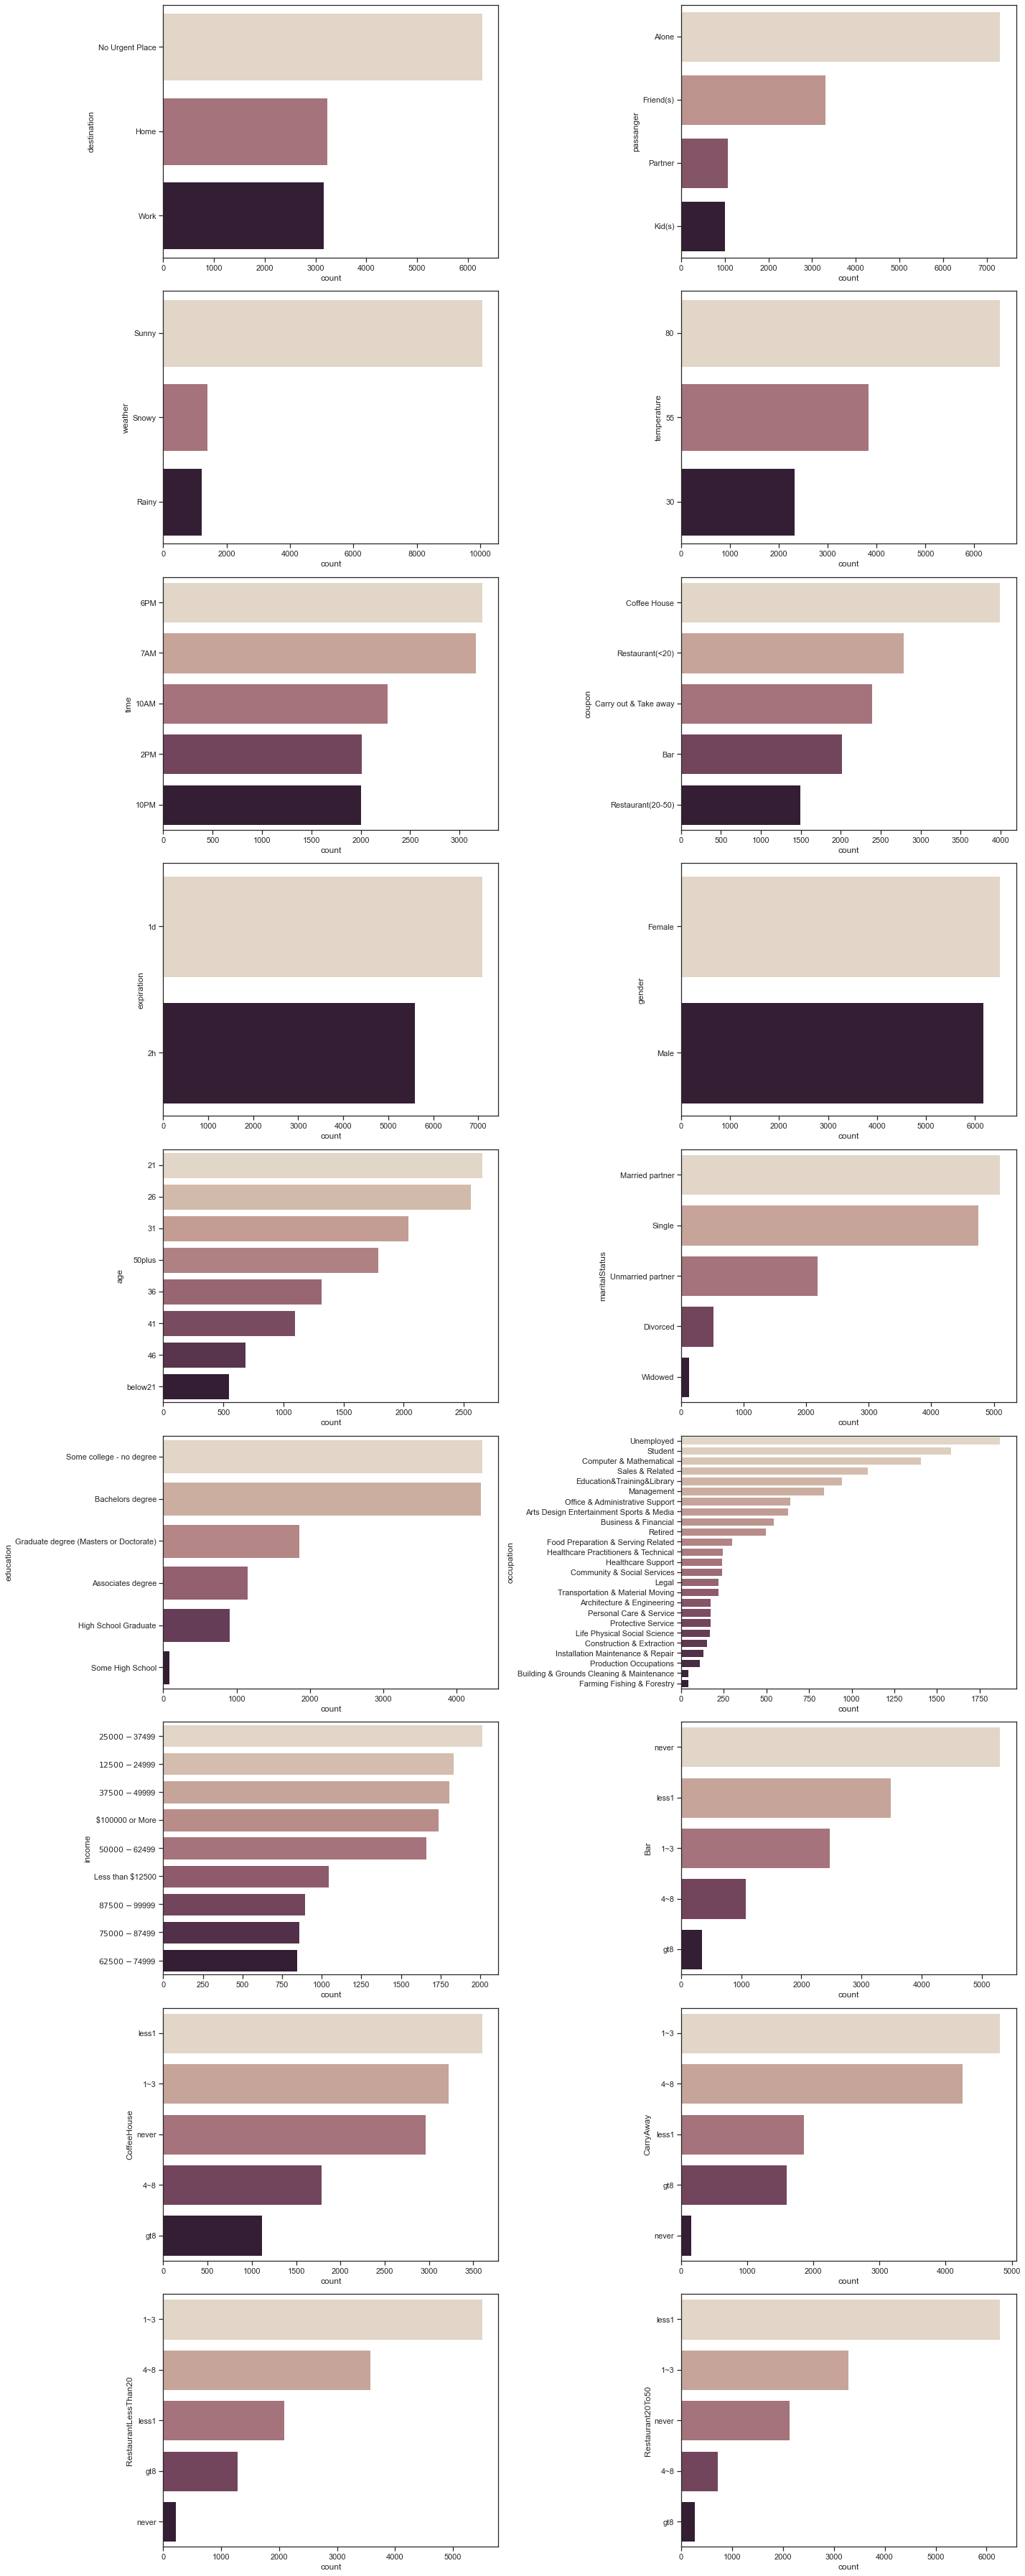

In [14]:
fig, axes = plt.subplots(9, 2, figsize=(20,50))
axes = axes.flatten()

for ax, col in zip(axes, df.select_dtypes('category').columns):
    sns.countplot(y=col, data=df, ax=ax, 
                  palette="ch:.25", order=df[col].value_counts().index);

plt.tight_layout()
plt.show()

### OneHotEncoder

We are going to create feature vectors for our modeling by using the LabelEnconder and OneHotEncoder.

In [15]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

enc = OneHotEncoder(dtype='int64')

df_cat = df.select_dtypes(include=['category']).copy()
df_int = df.select_dtypes(include=['int64']).copy()

df_enc = pd.DataFrame()
for col in df_cat.columns:
    
    enc_results = enc.fit_transform(df_cat[[col]])

    enc_cat = [col + '_' + str(x) for x in enc.categories_[0]]

    df0 = pd.DataFrame(enc_results.toarray(), columns=enc_cat)

    df_enc = pd.concat([df_enc,df0], axis=1)
    
df_final = pd.concat([df_enc, df_int], axis=1)

df_final

,destination_Home,destination_No Urgent Place,destination_Work,passanger_Alone,passanger_Friend(s),passanger_Kid(s),passanger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,...,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1
1,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
2,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,1,1,0,0,1,1
3,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,1,1,0,0,1,0
4,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,1
12680,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
12681,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
12682,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,1,0


In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_final, test_size=.2,\
                           random_state=42,\
                           shuffle=True, stratify=df_final['Y'])


### Feature importance

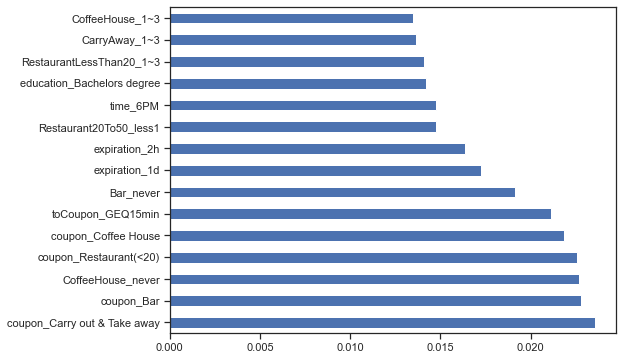

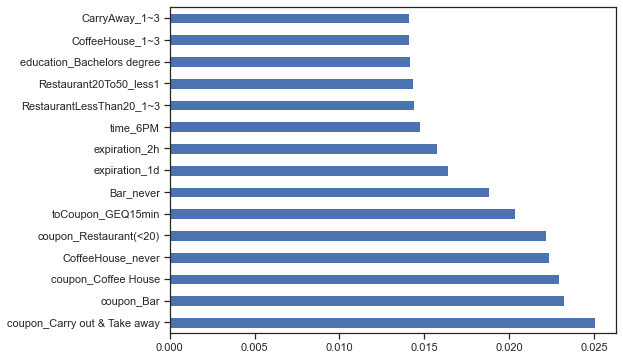

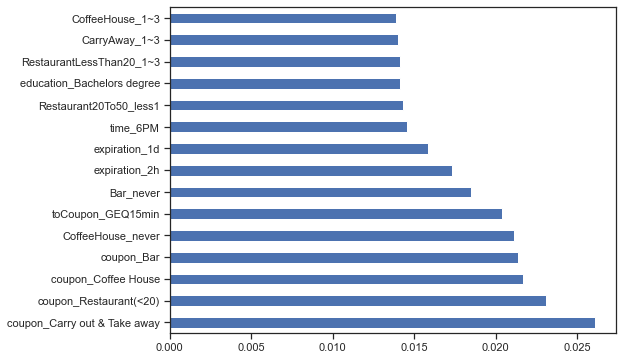

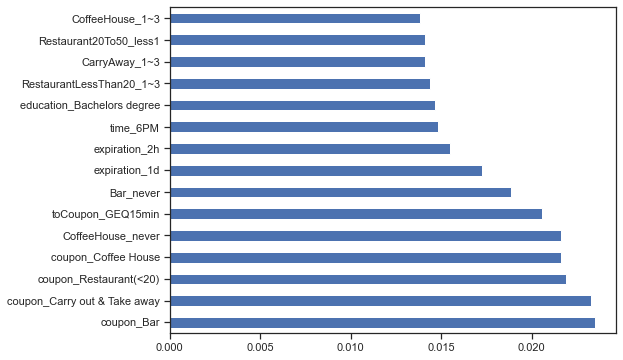

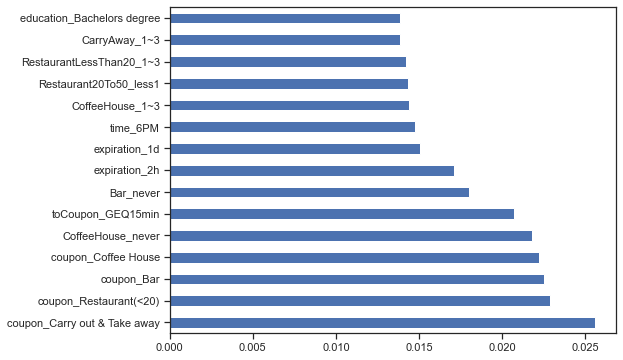

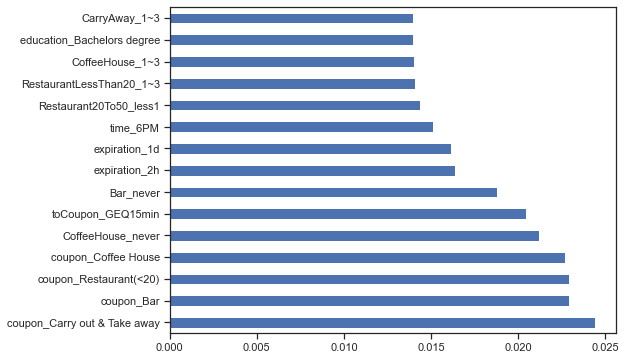

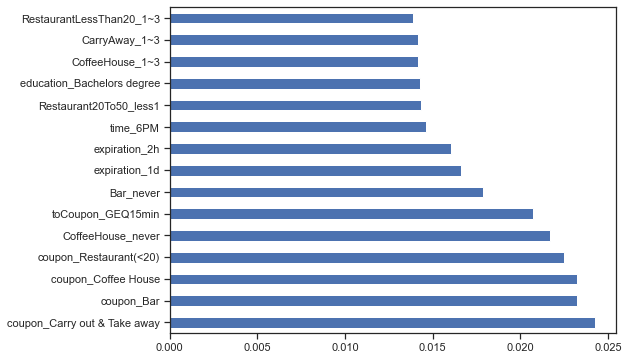

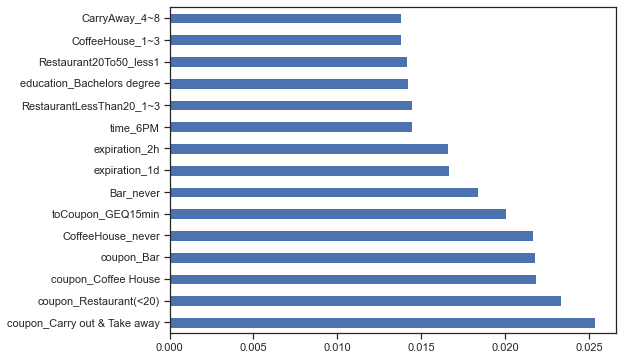

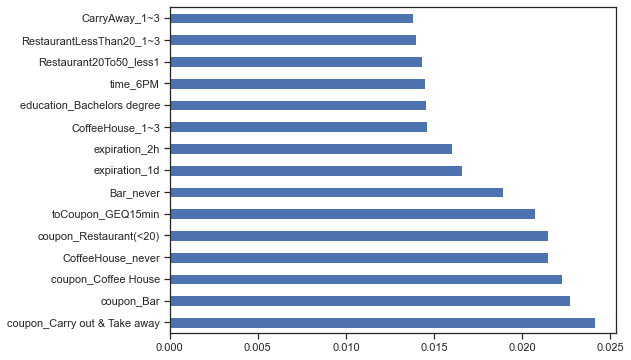

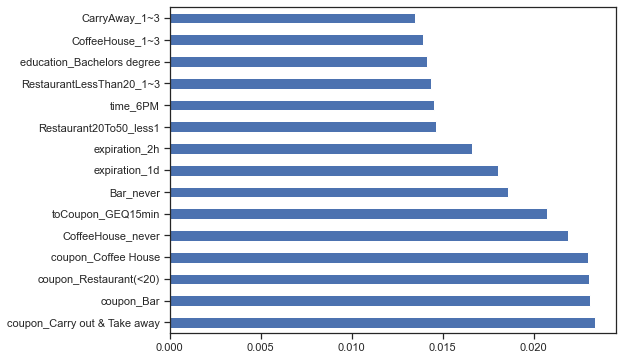

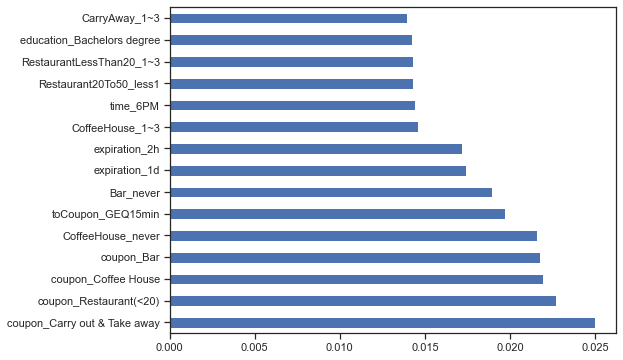

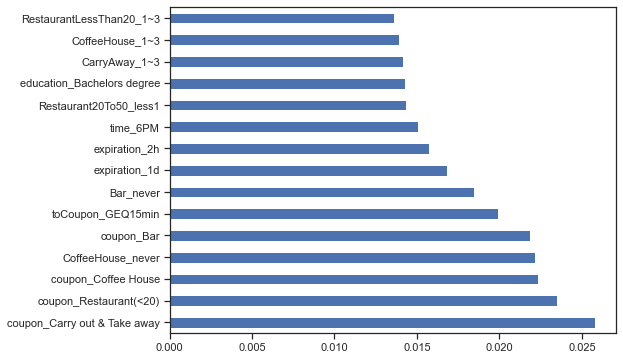

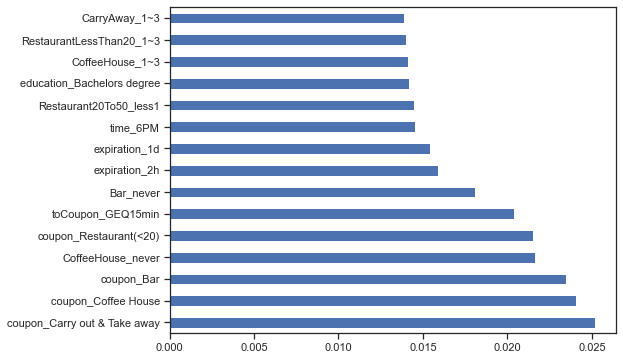

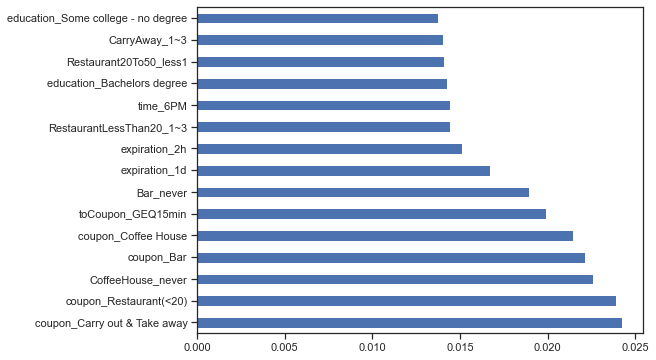

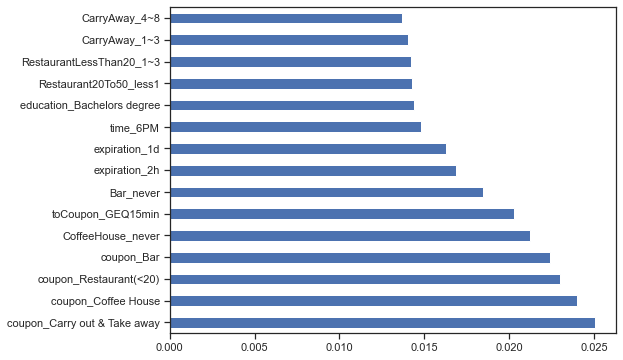

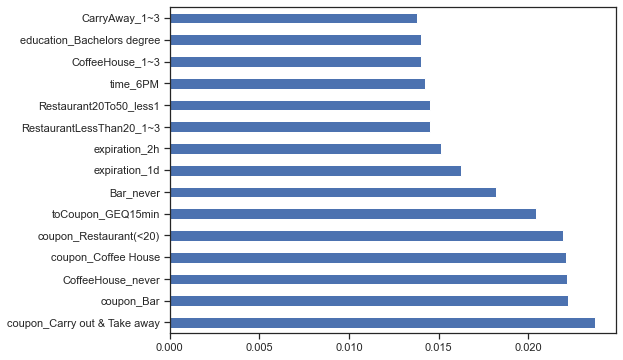

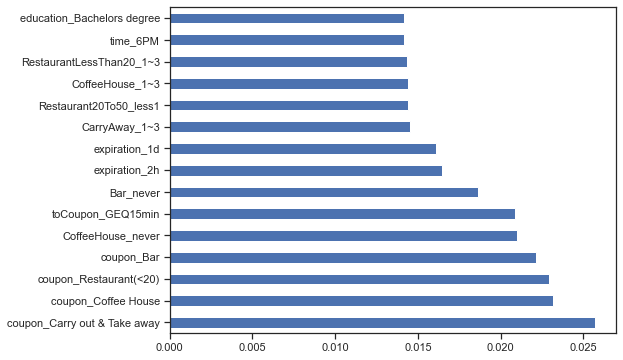

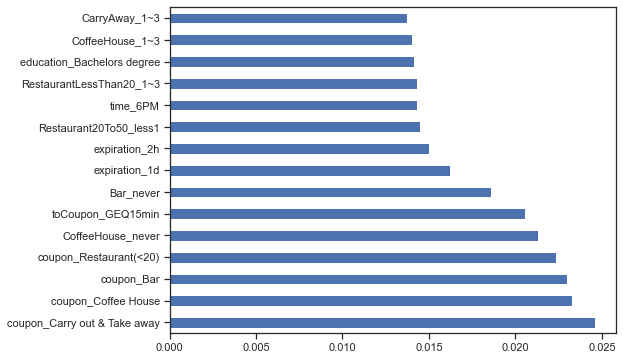

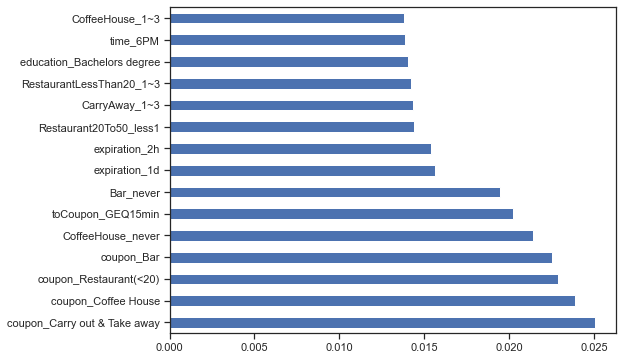

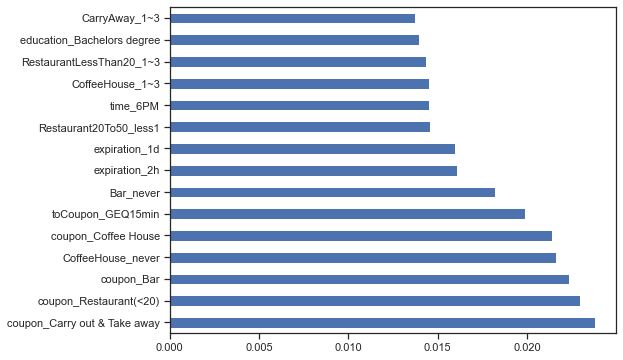

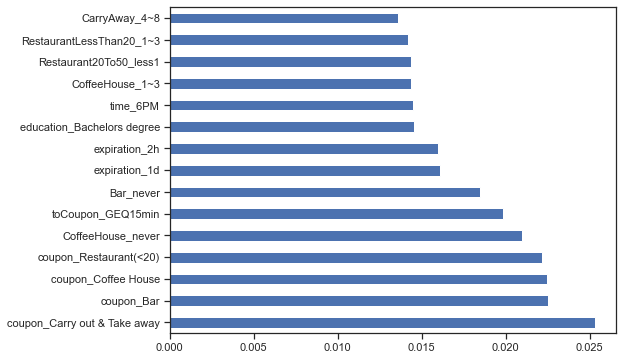

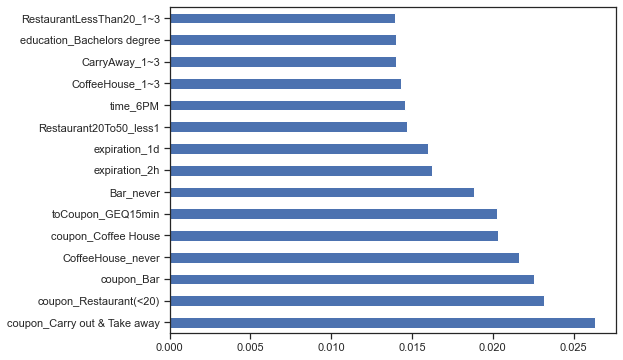

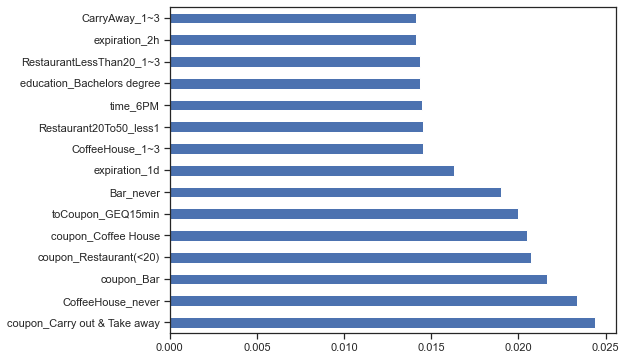

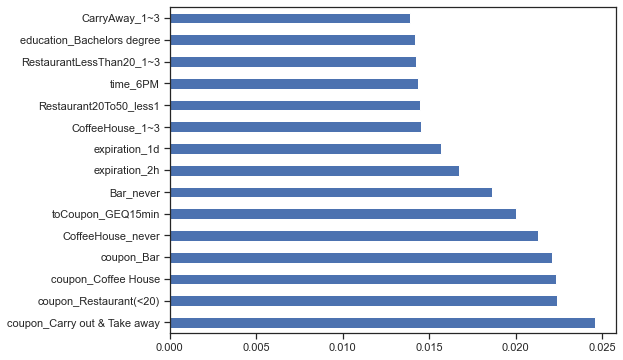

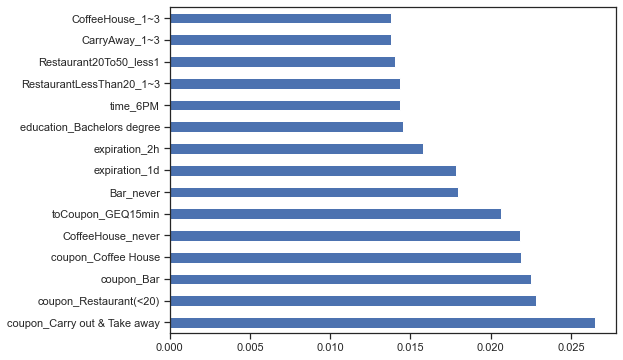

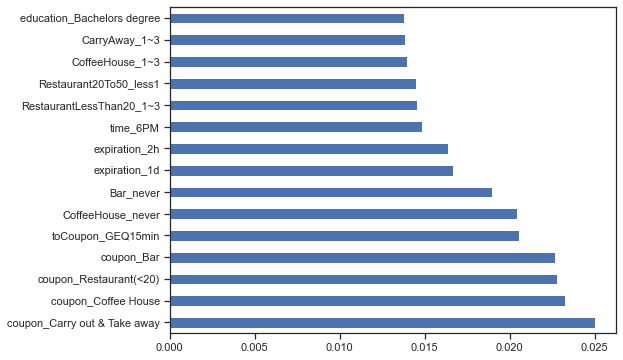

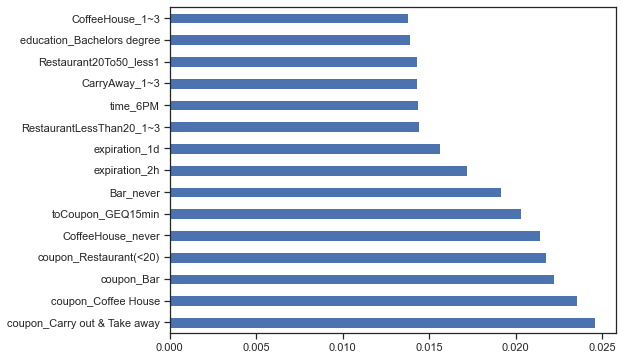

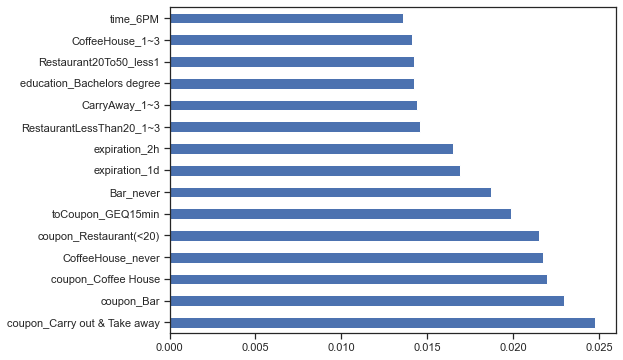

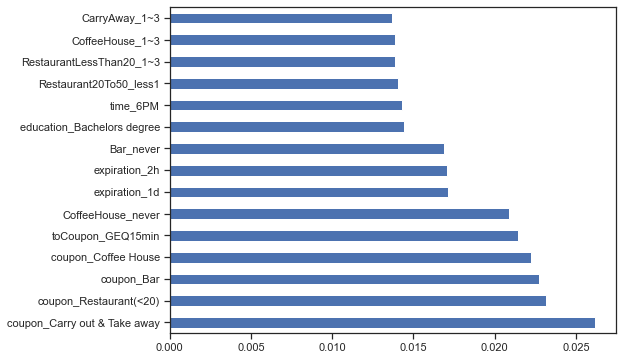

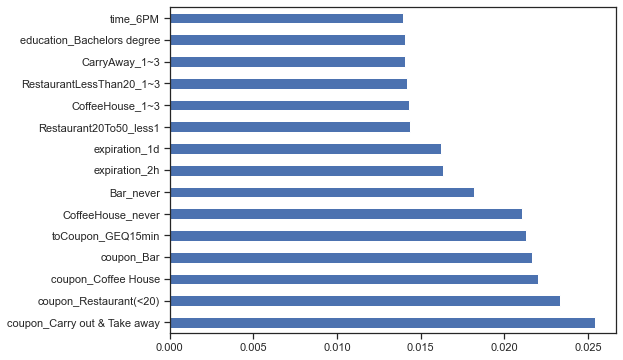

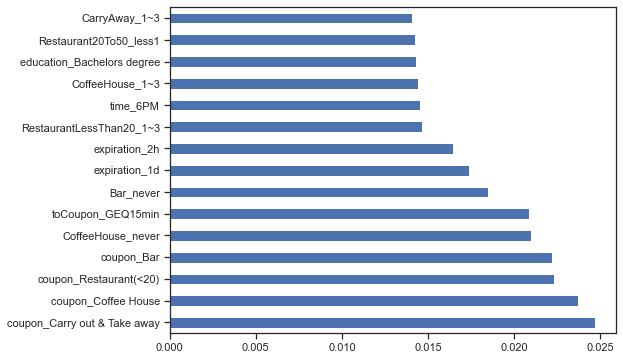

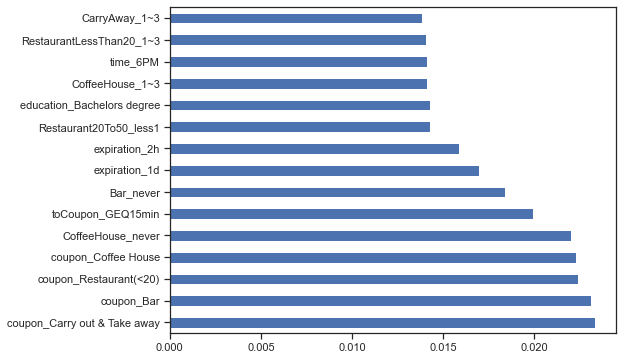

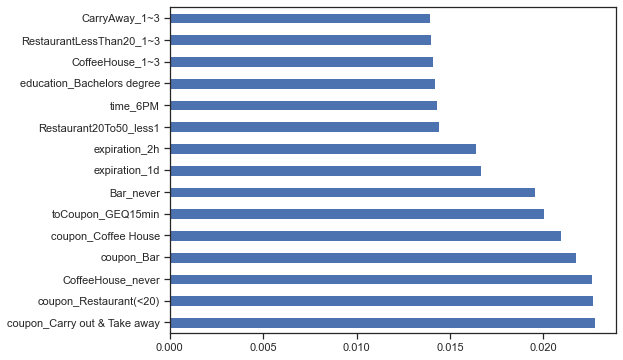

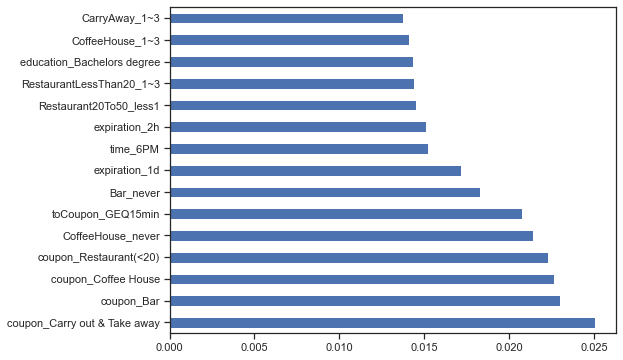

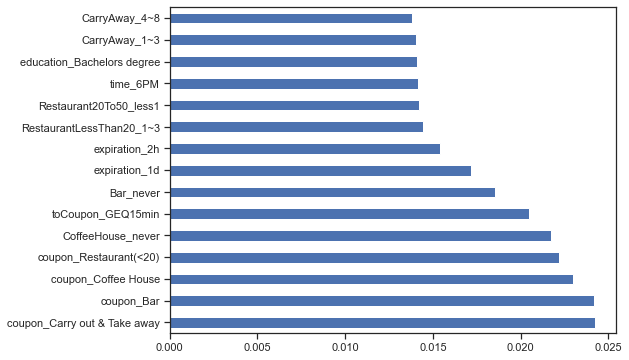

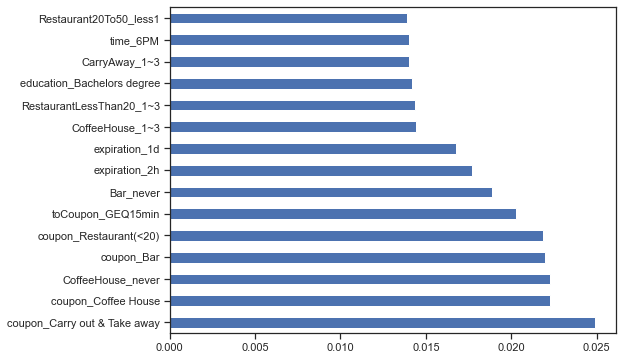

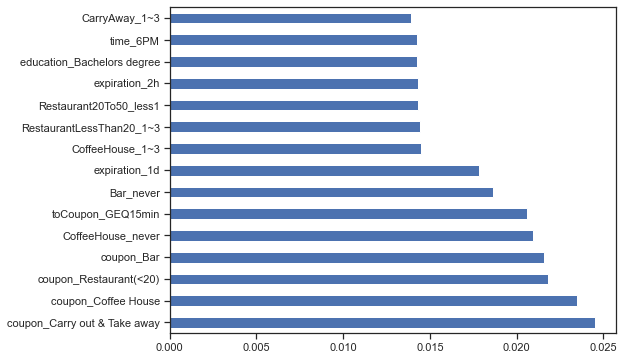

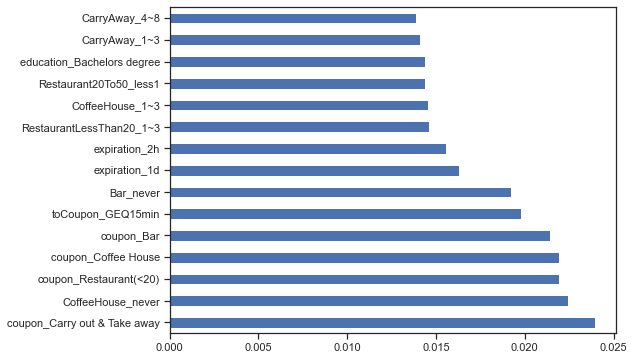

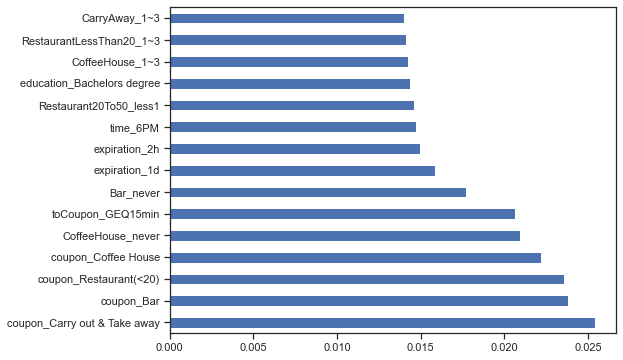

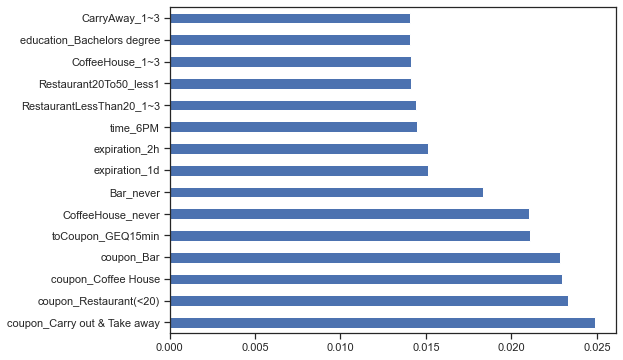

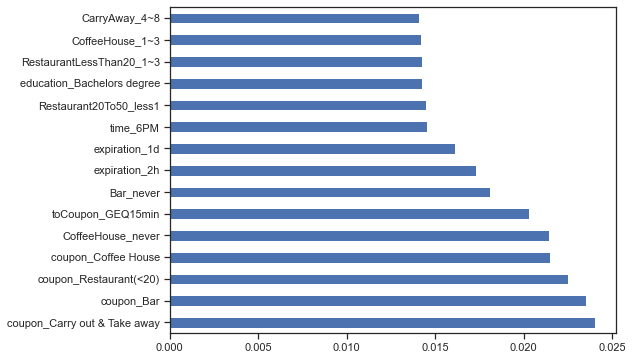

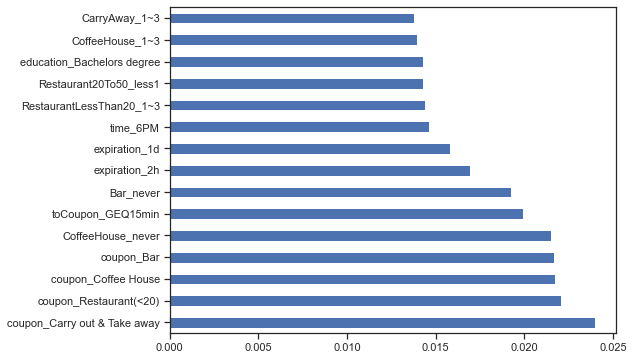

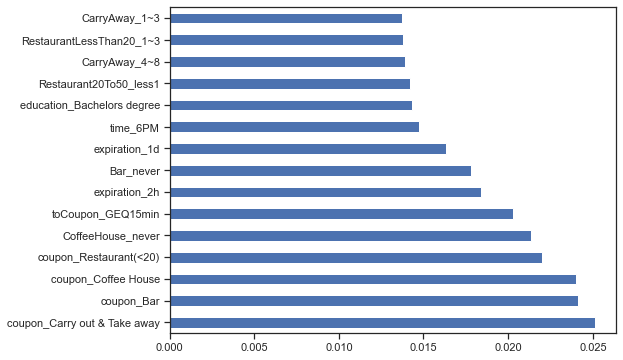

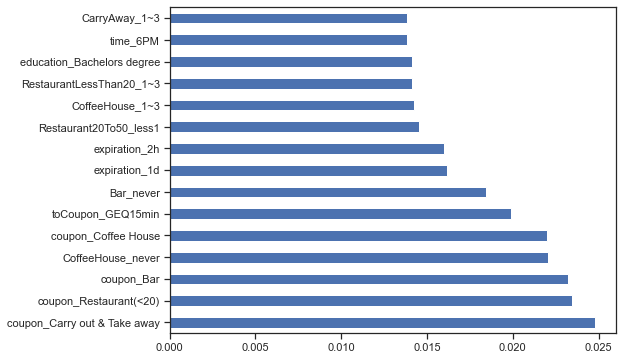

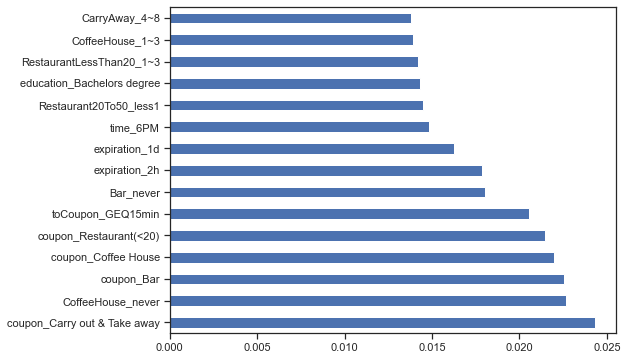

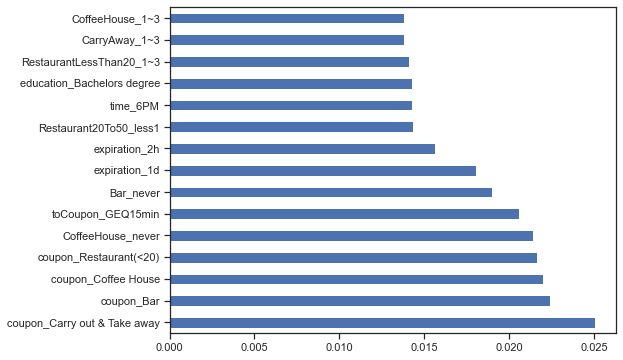

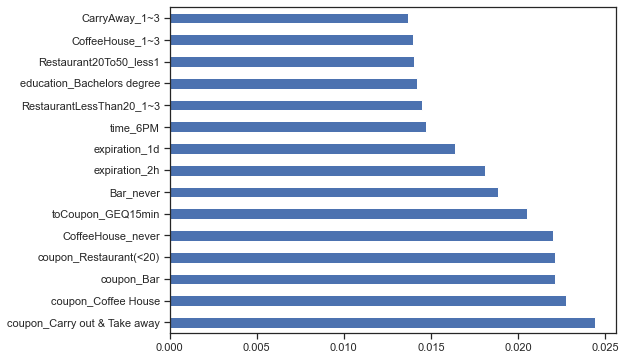

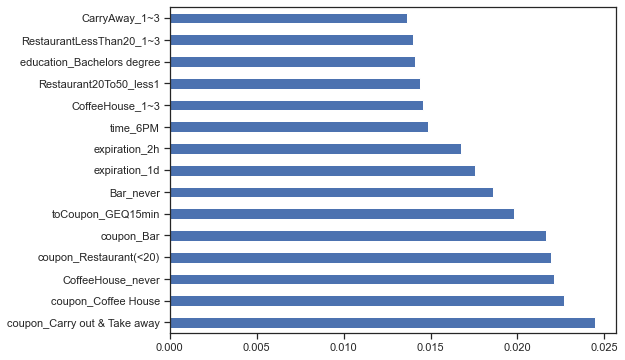

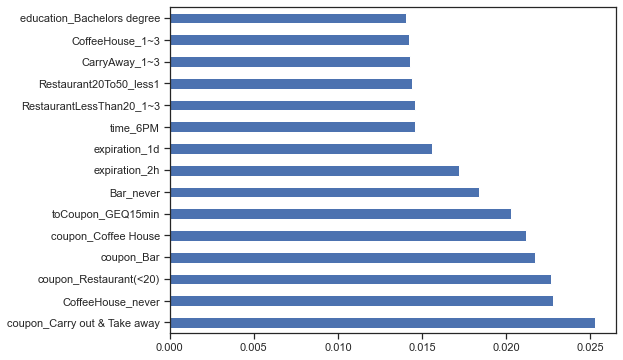

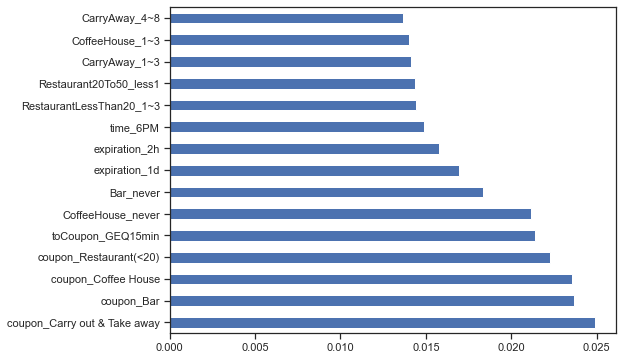

In [17]:
# X = data.iloc[:,0:20]  #independent columns
# y = data.iloc[:,-1]    #target column i.e price range
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html

from sklearn.ensemble import ExtraTreesClassifier
importances = dict()
for col in train_set.iloc[:,:-1].columns:
    importances[col] = 0

for i in range(50):
    model = ExtraTreesClassifier()
    model.fit(train_set.iloc[:,:-1], train_set.iloc[:,-1])
    matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
#     print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
#     print()
    feat_importances = pd.Series(model.feature_importances_, index=train_set.iloc[:,:-1].columns)
    for col in train_set.iloc[:,:-1].columns:
        importances[col] += dict(feat_importances)[col]
    feat_importances.nlargest(15).plot(kind='barh')
    plt.show()

newpd = pd.DataFrame()
for col in train_set.iloc[:,:-1].columns:
    newpd[col] = list([importances[col]])
newpd.to_csv('feature_importamce.csv', index=False)

### Oversampleing

In [18]:
count = Counter(df_final.iloc[:,-1])
count

Counter({1: 7210, 0: 5474})

Our data is not bias and we have enough samples in each category, thus we do not need to use oversampling methods.

In [19]:
# #preprocessing
# max_abs_scaler = preprocessing.MaxAbsScaler()
# X_train = max_abs_scaler.fit_transform(df_final.values[:,:-1])


# kmeans_smote = KMeansSMOTE(
#     kmeans_args={
#         'n_clusters': 10
#     },
#     smote_args={
#         'k_neighbors': 10
#     })
# X_train, y_train = kmeans_smote.fit_sample(X_train, df_final.values[:,-1])


# Tuning

In [20]:
# preprocessing
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html
max_abs_scaler = preprocessing.MaxAbsScaler()
train_set = pd.DataFrame(max_abs_scaler.fit_transform(train_set))
# scaler = preprocessing.StandardScaler()

In [32]:
'Support Vector Machine'

# defining parameter range for SVM
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['poly','rbf','sigmoid']}  
  
grid = GridSearchCV(SVC(), param_grid, n_jobs=-1, refit = True, verbose = 3, cv=5) 
 
# fitting the model for grid search 

grid.fit(train_set.iloc[:,:-1].values, train_set.iloc[:,-1].values)
grid.best_params_
'''
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
'''

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [21]:
'Random Forest'
## Using grid search
rf = RandomForestClassifier()
# Number of trees in random forest
n_estimators = list(range(40,201,40))
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(range(50, 160, 20))
# Minimum number of samples required to split a node
min_samples_split = [ 10, 30, 50, 70]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 5, 10, 15]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
}

grid = GridSearchCV(estimator = rf, param_grid = random_grid, n_jobs=-1, refit = True, verbose = 3, cv=5) 
 
# fitting the model for grid search 
grid.fit(train_set.iloc[:,:-1].values, train_set.iloc[:,-1].values)
grid.best_params_
print('Mean Accuracy: %.3f' % grid.best_score_)
print('Config: %s' % grid.best_params_)

'''
Fitting 5 folds for each of 960 candidates, totalling 4800 fits Mean Accuracy: 0.753
Config: {'max_depth': 150, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10,
'n_estimators': 200}
'''

SyntaxError: invalid syntax (<ipython-input-21-256e7fdd9777>, line 29)

In [ ]:
'Gaussian Naive Bayes'

nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
print(params_NB)

gs_NB = GridSearchCV(estimator=nb_classifier,
                 n_jobs=-1,
                 refit = True,
                 param_grid=params_NB, 
                 cv=5,   # use any cross validation technique 
                 verbose=3) 

gs_NB.fit(train_set.iloc[:,:-1].values, train_set.iloc[:,-1].values)

gs_NB.best_params_

'''
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'var_smoothing': 0.2848035868435802}'''

In [ ]:
'Linear Discriminant Analysis'
from numpy import arange
# define grid
grid = dict()
grid['solver'] = ['svd', 'lsqr', 'eigen']
grid['shrinkage'] = arange(0, 1, 0.1)
# define model
model = LinearDiscriminantAnalysis()
LDA_search = GridSearchCV(model, grid, n_jobs=-1, refit = True, cv=5, verbose=3) 
LDA_search.fit(train_set.iloc[:,:-1].values, train_set.iloc[:,-1].values)
# summarize
print('Mean Accuracy: %.3f' % LDA_search.best_score_)
print('Config: %s' % LDA_search.best_params_)

'''
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mean Accuracy: 0.685
Config: {'shrinkage': 0.2, 'solver': 'lsqr'}'''

In [ ]:
'Decision Tree'
DT = DecisionTreeClassifier()

criterion = ['gini', 'entropy']
max_depth =  list(range(60, 200, 10))
max_features = list(range(5, train_set.iloc[:,:-1].values.shape[1], 3))
min_samples_leaf = list(range(1, 31, 5))
min_samples_split = list(range(5, 31, 5))
presort = [False, True]

DT_param = {'criterion': criterion,
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split}

DT_grid = GridSearchCV(estimator = DT, param_grid = DT_param, n_jobs=-1, refit = True, verbose = 3, cv=5) 
# fitting the model for grid search 
DT_grid.fit(train_set.iloc[:,:-1].values, train_set.iloc[:,-1].values)
DT_grid.best_params_
# summarize
print('Mean Accuracy: %.3f' % DT_grid.best_score_)
print('Config: %s' % DT_grid.best_params_)
'''
Fitting 5 folds for each of 35280 candidates, totalling 176400 fits
Mean Accuracy: 0.708
Config: {'criterion': 'entropy', 'max_depth': 60, 'max_features': 68,\n
'min_samples_leaf': 26, 'min_samples_split': 30}'''

In [51]:
'Logistic Regression'
LR = LogisticRegression()
LRparam_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': list(range(100,800,100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
LR_search = GridSearchCV(LR, param_grid=LRparam_grid, n_jobs=-1, refit = True, verbose = 3, cv=5)

# fitting the model for grid search 
LR_search.fit(train_set.iloc[:,:-1].values, train_set.iloc[:,-1].values)

LR_search.best_params_
# summarize
print('Mean Accuracy: %.3f' % LR_search.best_score_)
print('Config: %s' % LR_search.best_params_)

'''
Fitting 5 folds for each of 490 candidates, totalling 2450 fits
Mean Accuracy: 0.685
Config: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}'''

Fitting 5 folds for each of 490 candidates, totalling 2450 fits


/home/amin/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.43155613        nan 0.56844387 0.65595748
 0.65595748 0.6579287  0.65595748 0.65595748        nan        nan
 0.43155613        nan 0.56844387 0.65595748 0.65595748 0.6579287
 0.65595748 0.65595748        nan        nan 0.43155613        nan
 0.56844387 0.65595748 0.65595748 0.6579287  0.65595748 0.65595748
        nan        nan 0.43155613        nan 0.56844387 0.65595748
 0.65595748 0.6579287  0.65595748 0.65595748        nan        nan
 0.43155613        nan 0.56844387 0.65595748 0.65595748 0.6579287
 0.65595748 0.65595748        nan        nan 0.43155613        nan
 0.56844387 0.65595748 0.65595748 0.6579287  0.65595748 0.65595748
        nan        nan 0.43155613        nan 0.56844387 0.65595748
 0.65595748 0.6579287  0.65595748 0.65595748        nan        nan
 0.65940479        nan 0.65940479 0.67901818 0.67901

Mean Accuracy: 0.685
Config: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [52]:
'K Neighbors Classifier'
  
## Using grid search
KNC = KNeighborsClassifier()
metric = ['euclidean','manhattan'] 
neighbors = np.arange(4, 21,2)
distances = list(range(1,10,2))
leaf_size = list(range(1,30,5))

# Create the random grid
KNC_param = {'metric': metric,
               'n_neighbors': neighbors,
               'p': distances,
               'leaf_size': leaf_size
}

KNC_grid = GridSearchCV(estimator = KNC, param_grid = KNC_param, n_jobs=-1, refit = True, verbose = 3, cv=5) 
 
# fitting the model for grid search 
KNC_grid.fit(train_set.iloc[:,:-1].values, train_set.iloc[:,-1].values)
KNC_grid.best_params_
print('Mean Accuracy: %.3f' % KNC_grid.best_score_)
print('Config: %s' % KNC_grid.best_params_)
'''
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Mean Accuracy: 0.699
Config: {'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 20, 'p': 1}'''

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Mean Accuracy: 0.699
Config: {'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 20, 'p': 1}


In [53]:
'Gradient Boosting'
GB = GradientBoostingClassifier()
param_test2 = {
    'learning_rate': [0.5, 0.25, 0.1, 0.05, 0.01],
    'n_estimators':range(1,61,15),
    'max_depth':range(10,101,15),
    'min_samples_split':list(range(5, 31, 5)),
    'min_samples_leaf':range(20,51,10),
    'max_features':range(5,26,5)
}

GB_search = GridSearchCV(estimator = GB, param_grid = param_test2, n_jobs=-1, refit = True, verbose = 3, cv=5)

# fitting the model for grid search 
GB_search.fit(train_set.iloc[:,:-1].values, train_set.iloc[:,-1].values)
# GB_search.best_params_
# summarize
print('Mean Accuracy: %.3f' % GB_search.best_score_)
print('Config: %s' % GB_search.best_params_)
'''
Fitting 5 folds for each of 16800 candidates, totalling 84000 fits
Mean Accuracy: 0.762
Config: {'learning_rate': 0.25, 'max_depth': 55, 'max_features': 25, 'min_samples_leaf': 20,\n
'min_samples_split': 20, 'n_estimators': 46}'''

Fitting 5 folds for each of 16800 candidates, totalling 84000 fits
Mean Accuracy: 0.762
Config: {'learning_rate': 0.25, 'max_depth': 55, 'max_features': 25, 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 46}


# Data Modeling

In [22]:
cat0 = shuffle(df_final[df_final ['Y']==0])
cat1 = shuffle(df_final[df_final ['Y']==1])

lenCat0 = len(cat0.iloc[:,0])  
lenCat1 = len(cat1.iloc[:,0])
   

In [23]:
methodList = []
accRes = []
accConf = []
nFold = 10
# sensitivityList = []
# specificityList = []

In [24]:
basicMethods = ['Gradient Boosting','Support Vector Machine','Logistic Regression','K Neighbors Classifier',\
                'Random Forest', 'Gaussian Naive Bayes', 'Linear Discriminant Analysis', 'Decision Tree']

methods = ['stacking classifir', 'soft votingClassifier', 'hard votingClassifier', 'BOA', 'Gradient Boosting',\
           'Support Vector Machine', 'Logistic Regression', 'K Neighbors Classifier', 'Random Forest',\
           'Gaussian Naive Bayes', 'Linear Discriminant Analysis', 'Decision Tree']
# methods = ['hard votingClassifier']

In [25]:
## 10 fold-CV

def classifiers(method):
    cl1 = LogisticRegression(C=0.1, max_iter=100, penalty='l2', solver='liblinear')
    cl2 = KNeighborsClassifier(leaf_size=1, metric='euclidean', n_neighbors=20, p=1)
    cl3 = RandomForestClassifier(max_depth=150, max_features='sqrt', min_samples_leaf=1,\
                                 min_samples_split=10, n_estimators=200)
    cl4 = GaussianNB(var_smoothing=0.2848035868435802)
    cl5 = LinearDiscriminantAnalysis(shrinkage=0.2, solver='lsqr')
    cl6 = DecisionTreeClassifier(criterion='entropy', max_depth=60, max_features=68,\
                                 min_samples_leaf=26, min_samples_split=30)
    cl7 = SVC(C=1, gamma= 0.1, kernel='rbf',probability=True)
    cl8 = GradientBoostingClassifier(learning_rate=0.25, max_depth=55, max_features=25,\
                                     min_samples_leaf=20, min_samples_split=20, n_estimators=46)
    estimator = [(basicMethods[0],cl8), (basicMethods[1],cl7), (basicMethods[2],cl1),\
                 (basicMethods[3],cl2), (basicMethods[4],cl3), (basicMethods[5],cl4),\
                 (basicMethods[6],cl5), (basicMethods[7],cl6)]
    
    if method == 'Logistic Regression':
        CL = LogisticRegression(C=0.1, max_iter=100, penalty='l2', solver='liblinear')
        
    if method == 'K Neighbors Classifier':
        CL = KNeighborsClassifier(leaf_size=1, metric='euclidean', n_neighbors=20, p=1)
        
    if method == 'Random Forest':
        CL = RandomForestClassifier(max_depth=150, max_features='sqrt', min_samples_leaf=1,\
                                 min_samples_split=10, n_estimators=200)
        
    if method == 'Gaussian Naive Bayes':
        CL = GaussianNB(var_smoothing=0.2848035868435802)
        
    if method == 'Linear Discriminant Analysis':
        CL = LinearDiscriminantAnalysis(shrinkage=0.2, solver='lsqr')
        
    if method == 'Decision Tree':
        CL = DecisionTreeClassifier(criterion='entropy', max_depth=60, max_features=68,\
                                 min_samples_leaf=26, min_samples_split=30)
        
    if method == 'Support Vector Machine':
        CL = SVC(C=1, gamma= 0.1, kernel='rbf',probability=True)
#         class_weight='balanced', C=1.0

    if method == 'Gradient Boosting':
        CL = GradientBoostingClassifier(learning_rate=0.25, max_depth=55, max_features=25,\
                                     min_samples_leaf=20, min_samples_split=20, n_estimators=46)
        
    if method == 'soft votingClassifier':
        CL = VotingClassifier(estimators=estimator, voting='soft', weights=[10, 3, 6, 5, 10, 5, 6, 8])
        
    if method == 'hard votingClassifier':
        CL = VotingClassifier(estimators=estimator, voting='hard')
    
    if method == 'stacking classifir':
        CL = StackingClassifier(estimators=estimator, final_estimator=cl1, cv=5)
    if method == 'BOA':
        """ parameters """
        # The following parameters are recommended to change depending on the size and complexity of the data
        N = 2000      # number of rules to be used in SA_patternbased and also the output of generate_rules
        Niteration = 500  # number of iterations in each chain
        Nchain = 2         # number of chains in the simulated annealing search algorithm

        supp = 5           # 5% is a generally good number. The higher this supp, the 'larger' a pattern is
        maxlen = 3         # maxmum length of a pattern

        # \rho = alpha/(alpha+beta). Make sure \rho is close to one when choosing alpha and beta. 
        alpha_1 = 500       # alpha_+
        beta_1 = 1          # beta_+
        alpha_2 = 500         # alpha_-
        beta_2 = 1 
        CL = 'BOA'
    print(type(CL))
    accList = []
    for j in range(nFold):

        i = j*.1
        k = (j+1)*.1
        #train
        X_train = cat0.iloc[int(k * lenCat0):,:-1].append(\
                  cat1.iloc[int(k * lenCat1):,:-1].append(\
                  cat0.iloc[:int(i * lenCat0),:-1].append(\
                  cat1.iloc[:int(i * lenCat1),:-1])))

        y_train = cat0.iloc[int(k * lenCat0):,-1].append(\
                  cat1.iloc[int(k * lenCat1):,-1].append(\
                  cat0.iloc[:int(i * lenCat0),-1].append(\
                  cat1.iloc[:int(i * lenCat1),-1])))
#         print(X_train.shape, y_train.shape)


        #preprocessing
        max_abs_scaler = preprocessing.MaxAbsScaler()
        X_train = max_abs_scaler.fit_transform(X_train)
        
#         scaler = preprocessing.StandardScaler()
#         print(X_train.shape)
#         X_train = scaler.fit_transform(X_train)

#         kmeans_smote = KMeansSMOTE(
#             kmeans_args={
#                 'n_clusters': 63
#             },
#             smote_args={
#                 'k_neighbors': 10
#             }
#         )
#         X_train, y_train = kmeans_smote.fit_sample(X_train, y_train)

        #test
        X_test = cat0.iloc[int(i * lenCat0):int(k * lenCat0),:-1].append(\
                 cat1.iloc[int(i * lenCat1):int(k * lenCat1),:-1])

        y_test = cat0.iloc[int(i * lenCat0):int(k * lenCat0),-1].append(\
                 cat1.iloc[int(i * lenCat1):int(k * lenCat1),-1])
#         print(X_test.shape, y_test.shape)
        X_test = max_abs_scaler.transform(X_test)
#         X_test = scaler.transform(X_test)   
        if CL != 'BOA':
            model = CL.fit(X_train, np.array(list(y_train)))
            predicts = np.array(model.predict(X_test))
        elif CL == 'BOA':
            model = BOA(df.iloc[train_index].reset_index(drop=True), Y.iloc[train_index].\
                        reset_index(drop=True))
            model.generate_rules(supp, maxlen,N)
            model.set_parameters(alpha_1, beta_1, alpha_2, beta_2, None, None)
            rules = model.SA_patternbased(Niteration, Nchain, print_message=True)

            # test
            predicts = predict(rules, df.iloc[test_index].reset_index(drop=True))
        cnf_matrix = metrics.confusion_matrix(y_test, predicts)
        print(method)
        print(cnf_matrix)
#         #matplotlib inline
#         class_names=[0,1] # name  of classes
#         fig, ax = plt.subplots()
#         tick_marks = np.arange(len(class_names))
#         plt.xticks(tick_marks, class_names)
#         plt.yticks(tick_marks, class_names)

#         # create heatmap
#         sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
#         ax.xaxis.set_label_position("top")
#         plt.tight_layout()
#         plt.title(method+ ' fold of '+str(j), y=1.1)

#         plt.ylabel('Actual label')
#         plt.xlabel('Predicted label')

#         plt.show()


        acc = metrics.accuracy_score(y_test.values, predicts)
        accList.append(acc)


    methodList.append(method)
    confidence = 0.95

    naccList = len(accList)
    maccList = np.mean(accList)
    std_erraccList = sem(accList)
    haccList = std_erraccList * t.ppf((1 + confidence) / 2, naccList - 1)




    print("Accuracy:         "+ str(round(maccList,2)) + '  -+' + str(round(haccList,4)))
    accRes.append(round(maccList,2))
    accConf.append(round(haccList,4))
    return (method, round(maccList,2), round(haccList,4))


In [ ]:
if __name__ == "__main__":
    p = Pool(processes=4)
    result1 = p.map(classifiers, methods)
    p.close()
    p.join()

<class 'sklearn.ensemble._stacking.StackingClassifier'><class 'sklearn.ensemble._voting.VotingClassifier'><class 'str'>

<class 'sklearn.ensemble._voting.VotingClassifier'>

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Gradient Boosting
[[387 160]
 [117 604]]
Gradient Boosting
[[418 129]
 [132 589]]
Gradient Boosting
[[397 151]
 [120 601]]
Gradient Boosting
[[403 144]
 [127 594]]
Gradient Boosting
[[376 172]
 [127 594]]
Gradient Boosting
[[369 178]
 [125 596]]
Gradient Boosting
[[374 173]
 [120 601]]
Gradient Boosting
[[393 155]
 [133 588]]
Gradient Boosting
[[388 159]
 [122 599]]
Gradient Boosting
[[384 164]
 [141 580]]
Accuracy:         0.78  -+0.0085
<class 'sklearn.svm._classes.SVC'>


In [ ]:
result = pd.DataFrame(result1)
result.columns = ['Method','Accuracy','ACC CI']

In [ ]:
result

In [ ]:
# # result = []
# result = pd.DataFrame(result1)
# result['Method'],result['Accuracy'],result['ACC CI'] = methodList,accRes,accConf
result.to_excel('result.xlsx',index=False)
result

SVM has the highest accuracy amongst the other models. I chose to use the RBF kernel as we do not know if the data is linear separable or not.  

For machine learning models, achieving a good prediction model is extremely crucial. It involves achieving a balance between underfitting and overfitting or ie. a trade-off between bias and variance.
<p>
When it comes to classification, the precision-recall trade-off is a fundamentally important metric to investigate.
</p>
<p>
Precision is the ratio between the True Positive and all Positives. For this problem it would be the measure of drivers that were correctly identified using a coupon out of all the drivers actually using it.
</p>
<p>
Recall is the measure of our model correctly identifying True Positives. Thus all the drivers who actually accepted a coupon, recall tells how many we correctly identified as accepting a coupon.
</p>

In [ ]:
# from sklearn.metrics import confusion_matrix

# cm_SVM = confusion_matrix(y_test,y_pred_SVM)
# pd.crosstab(y_test, y_pred_SVM, rownames = ['Truth'], colnames =['Predicted'], margins = True)

In [ ]:
# def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
#     df_cm = pd.DataFrame(
#         confusion_matrix, index=class_names, columns=class_names, 
#     )
#     fig = plt.figure(figsize=figsize)
#     try:
#         heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
#     except ValueError:
#         raise ValueError("Confusion matrix values must be integers.")
#     heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
#     heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
#     plt.ylabel('Truth')
#     plt.xlabel('Prediction')

# print_confusion_matrix(cm_SVM,["Coupon Not Accepted", "Coupon Accepted"])

A confusion matrix helps us gain an insight into how correct our predictions were and how they hold up against the actual values.

From our train and test data, we already know that our test data consisted of 3806 data points. That is the 3rd row and 3rd column value at the end. We also notice that there are some actual and predicted values. The actual values are the number of data points that were originally categorized into 0 or 1. The predicted values are the number of data points SVM model predicted as 0 or 1.<br>

The actual values are:
<ul>
    <li>The drivers who actually did not use a coupon = 1643</li>
    <li>The drivers who actually did use a coupon = 2163</li>
</ul><br>
The predicted values are:
<ul>
    <li>Number of drivers who were predicted as not using a coupon = 1401
    <li>Number of drivers who were predicted as using a coupon = 2396
</ul>

All the values we obtain above have a term. Let’s go over them one by one:
<ol>
    <li>The cases in which the drivers actually did not use a coupon and our model also predicted as not using one is called the <b>True Negatives</b>. For our matrix, True Negatives = 1056.
    <li>The cases in which the drivers actually used a coupon and our model also predicted as using one are called the <b>True Positives</b>. For our matrix, True Positives = 1809
    <li>However, there are are some cases where the drivers actually did not use a coupon, but our model has predicted that they did use one. This kind of error is the <b>Type I Error</b> and we call the values as <b>False Positives</b>. For our matrix, False Positives = 587
    <li>Similarly, there are are some cases where the drivers actually used a coupon, but our model has predicted that they did not use one. This kind of error is the <b>Type II Error</b> and we call the values as <b>False Negatives</b>.  For our matrix, False Negatives = 354
</ol>

## ROC Curves(Receiver Operating Characteristic Curve)

In [ ]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import auc

# y_pred_proba = SVM.predict_proba(X_test)[:,1]
# roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)
# #print(f'Receiver Operating Characteristic AUC = {roc_auc}')

# plt.figure(figsize = (10,8))
# # plot no skill roc curve
# plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# # calculate roc curve for model
# fpr, tpr, thresholds_ = roc_curve(y_test, y_pred_proba)
# # plot model roc curve
# plt.plot(fpr, tpr, marker='.', label='AUC = '+str(roc_auc))
# # axis labels
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve')
# # show the legend
# plt.legend(loc=4)
# # show the plot
# plt.show()

## Precision-Recall Curve (PRC)

In [ ]:
# precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# plt.figure(figsize = (10,8))
# plt.plot([0, 1], [0.5, 0.5],'k--', label = 'No Skill')
# prc_auc = auc(recall, precision)
# plt.plot(recall, precision, label = 'Precision-Recall AUC = '+str(prc_auc))
# plt.legend(loc=1)
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.show()

<ul>
<li>At the lowest point (0,0), the threshold is set to 1 which means the model make no distinctions between drivers who use coupons and drivers who do not use coupons.
<li>The highest point (1,1), the threshold is set at 0 which means that both precision and recall are high and the model makes distinctions perfectly. 
<li>The rest of the curve is the values of Precision and Recall for the threshold values between 0 and 1. Our aim is to make the curve as close to (1, 1) as possible- meaning a good precision and recall.
<li>Similar to ROC, the area with the curve and the axes as the boundaries is the Area Under Curve(AUC). Consider this area as a metric of a good model. The AUC ranges from 0 to 1.Therefore, we should aim for a high value of AUC.
</ul>

I just finished my Hon degree in IT with York University and this dataset it what I chose for project and decided to share the experience I had with you, so I am certainly open to new ideas and learning opportunities. 

Information Wo Wiase!